# Project Kojak - Crunchbase
### Daniel Shin


## Imports

In [173]:
# API
from pycrunchbase import *

# Python
import datetime
from collections import Counter
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import re
import json
from urllib2 import urlopen

# Database
from pymongo import MongoClient

# Graphing
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine learning
from sklearn.preprocessing import Imputer
from sklearn import utils
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from nltk import word_tokenize
from nltk import tokenize
from sklearn import preprocessing
from nltk.stem import PorterStemmer
import lshash
client = MongoClient()

## Load Data

In [2]:
# MONGODB
# initialize and access a kojak database and collection

db = client.kojak
crunch_ppl = db.crunch_ppl
orgs_api = db.orgs_api

In [3]:
# PYCRUNCHBASE
# use pycrunchbase wrapper to access crunchbase API using key

cb_api_key = "f724cd5232dd318067da50fd13ec28bc"
cb = CrunchBase(cb_api_key)

In [5]:
# OPEN DATA MAP
# read in data from open data map

orgs_odm_df = pd.read_csv("/Users/DanShin/Downloads/Data/odm/organizations.csv")
ppl_odm_df = pd.read_csv("/Users/DanShin/Downloads/Data/odm/people.csv")

In [4]:
# load in tabs of crunchbase_export.xls file as different dataframes
# companies (companies and aggregated funding information)
# rounds (summarized version of investments for each round - can disregard and just use investments)
# investments (info on company, their investments, funding round, amount raised)
# acquisitions (info on company, their acquirer, the price amount and currency)

companies = pd.read_excel(io="/Users/DanShin/Downloads/Data/crunchbase_export.xlsx", sheetname="Companies")
# rounds = pd.read_excel(io="/Users/DanShin/Downloads/Data/crunchbase_export.xlsx", sheetname="Rounds")
investments = pd.read_excel(io="/Users/DanShin/Downloads/Data/crunchbase_export.xlsx", sheetname="Investments")
# acquisitions = pd.read_excel(io="/Users/DanShin/Downloads/Data/crunchbase_export.xlsx", sheetname="Acquisitions")

## Preprocess

In [6]:
# preprocess data

orgs_odm_df = orgs_odm_df.drop("type", axis = 1)
orgs_odm_df = orgs_odm_df.drop("profile_image_url", axis = 1)

ppl_odm_df = ppl_odm_df.drop("type", axis = 1)
ppl_odm_df["name"] = ppl_odm_df.first_name + " " + ppl_odm_df.last_name

# combine names and insert to index 1
ppl_odm_df = ppl_odm_df.drop(["first_name", "last_name"], axis = 1)
columns = ppl_odm_df.columns.tolist()
columns.remove("name")
columns.insert(1, "name")
ppl_odm_df  = ppl_odm_df[columns]
ppl_odm_df = ppl_odm_df.drop("profile_image_url", axis = 1)

In [7]:
top_categories = Counter(investments.company_market).most_common(30)
top_categories = [str(cat[0]) for cat in top_categories]

In [8]:
comps_subset = investments[investments.company_market.isin(top_categories)]

In [9]:
market = top_categories[0][0]
num_per_round = Counter(investments.funding_round_code[investments.company_market == market])
fund_round_counts = num_per_round.items()
fund_round_counts = [x for x in fund_round_counts if type(x[0]) == unicode]  # remove nans
fund_rounds = [str(r[0]) for r in fund_round_counts]
fund_counts = [r[1] for r in fund_round_counts]

In [9]:
def clean_companies(companies_df):
    # convert erroneous datetimes to NaT
    companies_df.first_funding_at = companies_df.first_funding_at.apply(lambda x: np.nan if type(x) == unicode else x)
    # convert permalink format to integrate with API
    companies_df.permalink = companies_df.permalink.apply(lambda x: x.replace("/organization", "organizations"))
    # convert erroneus datetimes to NaT
    companies_df.founded_at = companies_df.founded_at.apply(lambda x: np.nan if type(x) == unicode else x)
    return companies_df

companies = clean_companies(companies)

## Visualize Data

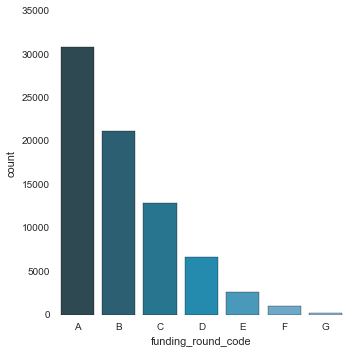

In [10]:
# histogram of all venture funding rounds

sns.factorplot("funding_round_code", data=investments, x_order=list("ABCDEFG"), palette="PuBuGn_d");

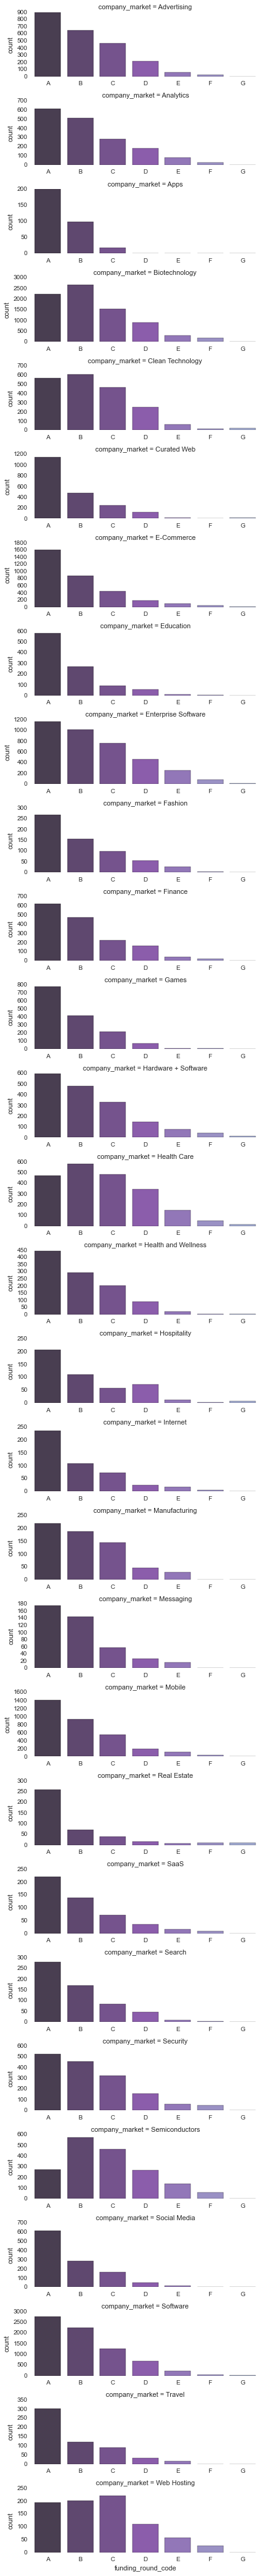

In [11]:
# histogram of venture funding rounds by market

sns.factorplot("funding_round_code", data=comps_subset, row="company_market", x_order=list("ABCDEFG"),
               margin_titles=False, aspect=3, size=2, palette="BuPu_d", sharex = False, sharey = False);

In [12]:
# show percent of companies operating, acquired, IPO, closed

def get_status_pct(companies):
    tot_companies = float(companies.status.shape[0])
    num_operating = sum(companies.status == "operating")/tot_companies
    num_acquired = sum(companies.status == "acquired")/tot_companies
    num_ipo = sum(companies.status == "ipo")/tot_companies
    num_closed = sum(companies.status == "closed")/tot_companies
    
    print "Total Percent Operating: " + str(round(num_operating * 100, 1)) + "%"
    print "Total Percent IPO: " + str(round(num_acquired * 100, 1)) + "%"
    print "Total Percent Acquired: " + str(round(num_ipo * 100, 1)) + "%"
    print "Total Percent Closed: " + str(round(num_closed * 100, 1)) + "%"

get_status_pct(companies)

Total Percent Operating: 82.6%
Total Percent IPO: 7.5%
Total Percent Acquired: 2.5%
Total Percent Closed: 5.3%


In [13]:
# get average number of funding rounds for status group

def get_avg_rounds(companies):
    avg_rounds_operating = np.mean(companies[companies.status == "operating"].funding_rounds)
    avg_rounds_ipo = np.mean(companies[companies.status == "ipo"].funding_rounds)
    avg_rounds_acquired = np.mean(companies[companies.status == "acquired"].funding_rounds)
    avg_rounds_closed = np.mean(companies[companies.status == "closed"].funding_rounds)

    print "Average Num Rounds Operating: " + str(round(avg_rounds_operating, 2))
    print "Average Num Rounds IPO: " + str(round(avg_rounds_ipo, 2))
    print "Average Num Rounds Acquired: " + str(round(avg_rounds_acquired, 2))
    print "Average Num Rounds Closed: " + str(round(avg_rounds_closed, 2))
    
get_avg_rounds(companies)

Average Num Rounds Operating: 1.67
Average Num Rounds IPO: 2.68
Average Num Rounds Acquired: 2.05
Average Num Rounds Closed: 1.49


In [14]:
# from companies that have IPO'd get 

Counter(companies[companies.status == "ipo"].market).most_common(10)

[(u'Biotechnology', 422),
 (u'Software', 93),
 (u'Health Care', 63),
 (u'Clean Technology', 49),
 (u'Hardware + Software', 46),
 (u'Mobile', 41),
 (u'E-Commerce', 36),
 (u'Semiconductors', 35),
 (u'Curated Web', 26),
 (u'Manufacturing', 26)]

Early stage startups: which ones affect your growth.
Try to find out what makes early stage startups successful and categorize them.
What are the characteristics of each startup or fund?
Do a vertical barplot for each industry, broken down by percent of funding in each category.
Do an analysis of raised_amount_usd by funded_year
Do an analysis of raised_amount_usd by funded_month
Do an analysis of average time to IPO/acquisition by year of exit
Investor market

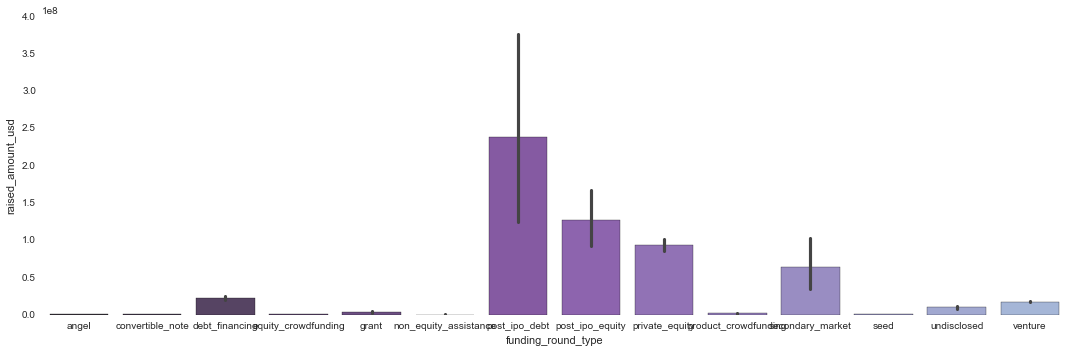

In [15]:
# plot of aggregated amount raised by funding_round_type

sns.factorplot("funding_round_type", "raised_amount_usd", data=investments,
               margin_titles=False, aspect=3, size=5, palette="BuPu_d", sharex = False, sharey = False);

In [16]:
# aggregated view of type of funding rounds

Counter(investments.funding_round_type)

Counter({u'venture': 97456, u'seed': 47069, u'angel': 6792, u'undisclosed': 5847, u'debt_financing': 3351, u'private_equity': 2658, u'convertible_note': 1713, u'grant': 1514, u'equity_crowdfunding': 1421, u'post_ipo_equity': 446, u'product_crowdfunding': 150, u'non_equity_assistance': 148, u'post_ipo_debt': 140, u'secondary_market': 98})

In [22]:
# Total price of acquisitions by year - Going up (big spike in 2014)

acquisitions.groupby("acquired_year").sum().plot(kind = "bar")

NameError: name 'acquisitions' is not defined

In [17]:
# total funding rounds for acquired companies

Counter(companies[companies.status == "acquired"].funding_rounds)

Counter({1: 2107, 2: 1026, 3: 591, 4: 284, 5: 139, 6: 82, 7: 40, 8: 13, 9: 10, 10: 5, 11: 4, 15: 1})

In [ ]:
# for company in companies.permalink:
#     comp_name = company[14:]
#     try:
#         comp_api = cb.organization(comp_name)
#     except:
#         print "Error: " + comp_name
#         continue
#     orgs_api.insert(comp_api.data)

Error: 1000jobboersen-de
0:02:03.860596
Error: 3d-systems
Error: 58-com
Error: 5barz-international
Error: a-power-energy-generation
Error: abattis-bioceuticals
Error: abbott
Error: ablynx
Error: accelera-innovations
Error: accelerize-new-media
Error: access-pharmaceuticals
Error: acco-brands
Error: acorn-international
Error: acs-global
Error: actinium-pharmaceuticals
Error: activenetwork
Error: acusphere
Error: adaptive-media
Error: adcare-health-systems
Error: adslinked
Error: advanced-media
Error: aeropostale
Error: affymax
Error: agenus
Error: airspan-networks
Error: airtouch-communications
Error: alere
Error: alldigital
Error: allon-therapeutics
Error: altigen-communications
Error: altran
Error: ambient-corporation
Error: ambow-education
Error: american-addiction-centers
Error: american-apperal
Error: american-cannabis-company
Error: american-restaurant-concepts
Error: ampio-pharmaceuticals
Error: ampliphi-biosciences
Error: anavex
Error: anda
Error: anesiva
Error: envirosystems-i

In [13]:
with open("errors.txt", "r") as f:
    errors = f.read()

In [18]:
company_errors = errors.replace("Error: ", "").split("\n")

In [70]:
# start where it was interrupted

for comp_name in company_errors:
    try:
        url = urlopen("https://api.crunchbase.com/v/3/organizations/" + comp_name + "?user_key=f724cd5232dd318067da50fd13ec28bc")
        data_string = url.read()
        json_file = json.loads(data_string)
    except:
        print "Error: " + comp_name
        continue
    orgs_api.insert(json_file["data"])

Error: 1000jobboersen-de
Error: adslinked
Error: asiansbook
Error: asktourism
Error: avis-2
Error: complex-media
Error: connect-hq
Error: contactpoint
Error: corenergy-infrastructure-trust
Error: corindus
Error: cormedix
Error: cortendo
Error: cortex-business-solutions
Error: crexendo
Error: shadowdcat-consulting
Error: freem?
Error: green-mountain-digital
Error: ?novatiff-reklam-ve-tan?t?m-hizmetleri-tic
Error: iproof---the-foundation-for-the-internet-of-things
Error: its-all-about-me
Error: klink-technologies
Error: knownact
Error: luma-legacy-2
Error: ob1-2
Error: on-the-run-tech
Error: patrof?n
Error: prod?ti-cz
Error: prze?wietl-pl
Error: socialchorus
Error: sociocast-networks
Error: soligenix
Error: somedia-bbn3
Error: spire-corporation
Error: spot-coffee
Error: spotlight-innovation
Error: sprylogics-international-corp
Error: talentsigned
Error: tutored-2
Error: vacation-bnb
Error: wavemaker-software
Error: whites-holdings
Error: whodats-spaces


In [24]:
total = orgs_api.count()
has_team = 0

for org in orgs_api.find():
    if "current_team" in org["relationships"]:
        has_team += 1
    
print float(has_team)/total

KeyError: 'relationships'

In [25]:
# extract school info from people

school = []
for entry in some_person.data["relationships"]["degrees"]["items"]:
    entry_nested = entry["relationships"]["school"]["properties"]["name"]
    school.append(entry_nested)

NameError: name 'some_person' is not defined

## Build DataFrames

In [18]:
# get company names
def get_names(list_of_companies):
    names = list_of_companies.name
    return names

# get matrix with category of each company
def get_categories(list_of_companies):
    # preprocess category_list
    categories = list_of_companies.category_list
    categories[categories.isnull()] = ''
    categories = categories.str.replace(' ', '-')
    categories = categories.str.strip('|')
    categories = categories.apply(lambda x: x.replace("|", " "))
    # tokenize and vectorize
    category_counts = CountVectorizer(tokenizer = tokenize.word_tokenize)
    sparse_matrix = category_counts.fit_transform(categories)
    return sparse_matrix.todense()

def get_market(list_of_companies):
    market = list_of_companies.market
    return market

def get_funding_rounds(list_of_companies):
    num_rounds = list_of_companies.funding_rounds
    return num_rounds

def get_funding_total(list_of_companies):
    # around 10,000 of 57,000 companies have 0 funding in the database???
    funding_total_usd = list_of_companies.funding_total_usd
    return funding_total_usd

def get_founded_year(list_of_companies):
    founded_year = list_of_companies.founded_year
    return founded_year

def get_founded_month(list_of_companies):
    founded_month = list_of_companies.founded_month
    founded_month = founded_month.apply(lambda x: int(x[5:]) if type(x) == unicode else np.nan)
    return founded_month

def get_founded_quarter(list_of_companies):
    quarter = list_of_companies.founded_quarter
    quarter = quarter.apply(lambda x: int(x[6:]) if type(x) == unicode else x)
    return quarter

def get_first_funding(list_of_companies):
    first_funding = list_of_companies.first_funding_at
    return first_funding
    
def get_last_funding(list_of_companies):
    last_funding = list_of_companies.last_funding_at
    return last_funding

def time_to_first_funding(list_of_companies):
    time_to_first = list_of_companies.first_funding_at - list_of_companies.founded_at
    def filter_time(x):
        if x != pd.NaT:
            return x
        else:
            return "OMG"
    time_to_first = time_to_first.apply(lambda x: filter_time(x))
    return time_to_first

def get_funding_round(list_of_companies, funding_type, series_letter = None):
    companies_funds = []
    
    for company in list_of_companies.permalink:
        # find the company 
        mongo_call = orgs_api.find_one({"properties.api_path" : company})
        try: # try getting funding info
            funding_info = mongo_call["relationships"]["funding_rounds"]["items"]
        except: # add nan if can't access
            companies_funds.append(np.nan)
            continue
            
        amount = 0
        
        for fund_round in funding_info: 
            # check if funding type is same
            same_type = fund_round["properties"]["funding_type"].lower() == funding_type
            # check if funding_round has value
            is_a_value = hasattr(fund_round["properties"]["series"], "upper")
            # if not same funding type, do nothing
            if not same_type:
                continue
            # if series info is available, check to see if same
            else:
                try:
                    series = fund_round["properties"]["series"].upper()
                except:
                    series = None
                if series_letter == series:
                    try:
                        amount += fund_round["properties"]["money_raised_usd"]
                    except:
                        pass
        if amount > 0:
            companies_funds.append(amount)
        else:
            companies_funds.append(np.nan)
    return companies_funds

def get_news(list_of_companies):
    num_news = []
    for company in list_of_companies.permalink:
        mongo_call = orgs_api.find_one({"properties.api_path" : company})
        try:
            news = mongo_call["relationships"]["news"]["paging"]["total_items"]
            num_news.append(news)
        except:
            num_news.append(np.nan)
            continue
    return np.array(num_news)

def get_num_founders(list_of_companies):
    list_num_founders = []
    for company in list_of_companies.permalink:
        mongo_call = orgs_api.find_one({"properties.api_path" : company})
        try:
            num_founders = len(mongo_call["relationships"]["founders"]["items"])
            list_num_founders.append(num_founders)
        except:
            list_num_founders.append(np.nan)
    return list_num_founders

def get_status(list_of_companies):
    list_of_status = list_of_companies.status
    return list_of_status

In [19]:
exited_companies = companies[(companies["status"] != "operating") & (pd.notnull(companies["status"]))]

In [20]:
companies.founded_at = companies.founded_at.apply(lambda x: np.nan if type(x) == unicode else x)

In [21]:
# names = get_names(company_df)
# categories = get_categories(company_df)
# num_funding_rounds = get_funding_rounds(company_df)
# funding_total = get_funding_total(company_df)
# founded_year = get_founded_year(company_df)
# founded_month = get_founded_month(company_df)
# founded_quarter = get_founded_quarter(company_df)
# first_funding = get_first_funding(company_df)
# last_funding = get_last_funding(company_df)
# time_to_first = time_to_first_funding(company_df)
# num_news = get_news(company_df)
# series_a_amounts = get_series_funding(company_df, "A")
# series_b_amounts = get_series_funding(company_df, "B")
# series_c_amounts = get_series_funding(company_df, "C")
# series_d_amounts = get_series_funding(company_df, "D")
# seed = get_seed(company_df)
# angel = get_angel(company_df)
# num_founders = get_num_founders(company_df)
# market = get_market(company_df)
# status = get_status(company_df)

In [73]:
def get_features(company_df):
    market = get_market(company_df)
    num_founders = get_num_founders(company_df)
    seed = get_funding_round(company_df, "seed")
    angel = get_funding_round(company_df, "angel")
    series_a_amounts = get_funding_round(company_df, "venture", "A")
    series_b_amounts = get_funding_round(company_df, "venture", "B")
    series_c_amounts = get_funding_round(company_df, "venture", "C")
    series_d_amounts = get_funding_round(company_df, "venture", "D")
    num_news = get_news(company_df)
    time_to_first = time_to_first_funding(company_df)
    founded_year = get_founded_year(company_df)
    founded_month = get_founded_month(company_df)
    founded_quarter = get_founded_quarter(company_df)
    status = get_status(company_df)

    df = pd.DataFrame(data = {
# "market" : market, 
                              "num_founders" : num_founders,
                              "seed" : seed,
                              "angel" : angel, 
                              "series_a" : series_a_amounts, 
                              "series_b" : series_b_amounts, 
                              "series_c" : series_c_amounts, 
                              "series_d" : series_d_amounts,
                              "num_news_articles" : num_news,
                              "founded_year" : founded_year,
                              "founded_month" : founded_month,
                              "founded_quarter" : founded_quarter,
                              "status" : status
                              })
    return df

In [22]:
seed = get_funding_round(exited_companies, "seed")

In [74]:
exit_df = get_features(exited_companies)

In [75]:
exit_outcome = exit_df.status
exit_predictors = exit_df.drop("status", axis = 1)
na_impute = Imputer()
exit_predictors = pd.DataFrame(na_impute.fit_transform(exit_predictors))
exit_predictors = pd.DataFrame(preprocessing.scale(exit_predictors))

In [78]:
rf.classes_

array([u'acquired', u'closed', u'ipo'], dtype=object)

In [76]:
rf = RandomForestClassifier()
rf.fit(exit_predictors, exit_outcome)
rf.predict_proba(exit_predictors)

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.9       ,  0.1       ,  0.        ],
       [ 0.33416182,  0.38712799,  0.27871019],
       ..., 
       [ 0.9       ,  0.1       ,  0.        ],
       [ 0.4       ,  0.        ,  0.6       ],
       [ 0.58      ,  0.30714286,  0.11285714]])

In [80]:
cross_val_score(RandomForestClassifier(), exit_predictors, exit_outcome, scoring = "recall", )

/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

array([ 0.57446809,  0.56642636,  0.57486264])

In [83]:
Counter(exit_outcome)

Counter({u'acquired': 4302, u'closed': 3032, u'ipo': 1405})

In [544]:
np.sum(series_a_amounts > 0)

9303

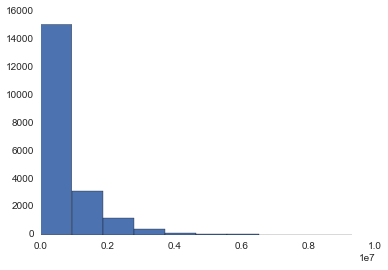

In [381]:
pd.Series(seed[seed < 10000000]).hist()

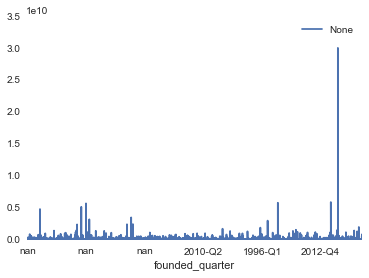

In [101]:
companies.plot("founded_quarter", "funding_total_usd")

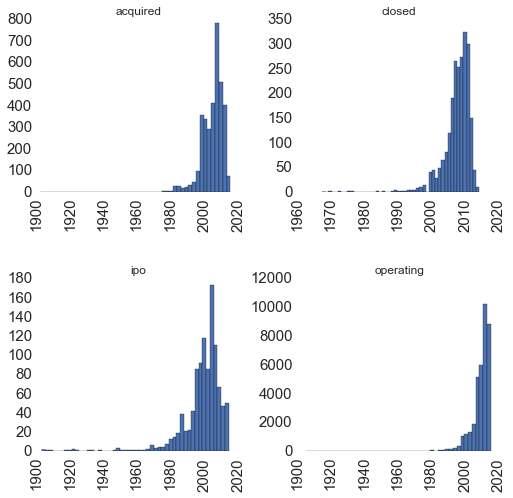

In [649]:
companies.hist("founded_year", by = "status", bins = 50, xlabelsize = 15, ylabelsize = 15, figsize = (8,8))
plt.savefig("plot.png")

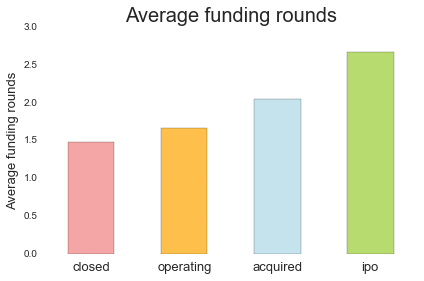

In [107]:
avg_fund_round_plot = companies.groupby("status")["funding_rounds"].mean()
avg_fund_round_plot.sort()

avg_fund_round_plot.plot(kind = "bar", figsize = (6,4), rot = 0, alpha = 0.7, color = ["lightcoral", "orange", "lightblue", "yellowgreen"])
plt.xticks(size = 13)
plt.title("Average funding rounds", size = 20)
plt.xlabel("")
plt.ylabel("Average funding rounds", size = 13)
plt.tight_layout()
plt.savefig("barplot.png")

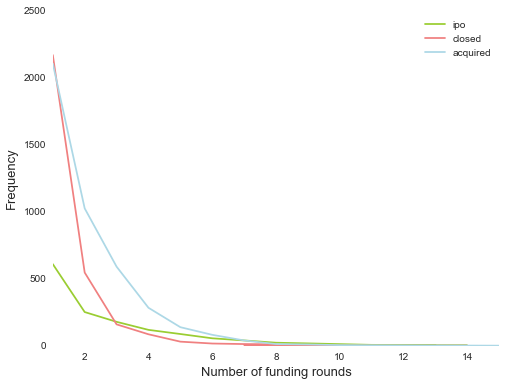

In [109]:
closed_funding = companies[companies.status == "closed"]["funding_rounds"].value_counts()
ipo_funding = companies[companies.status == "ipo"]["funding_rounds"].value_counts()
acquired_funding = companies[companies.status == "acquired"]["funding_rounds"].value_counts()

plt.figure(figsize=(8,6))
ipo_funding.plot(color = "yellowgreen")
closed_funding.plot(color = "lightcoral")
acquired_funding.plot(color = "lightblue")
plt.legend(["ipo", "closed", "acquired"])
plt.xlabel("Number of funding rounds", size = 13)
plt.ylabel("Frequency", size = 13)
plt.savefig("funding_round_line.png")

In [119]:
comps_over8_rounds = list(companies[companies.funding_rounds > 8]["name"].apply(lambda x: x.encode('utf-8')))

In [534]:
perm_over8_rounds = []
names = list(companies["name"])
permalinks = list(companies["permalink"])

for comp in comps_over8_rounds:
    try:
        i = names.index(comp)
        a = permalinks[i]
        a = a[14:]
        perm_over8_rounds.append(a)
    except:
        continue

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [539]:
# get 2nd page results that were not picked up the first time

for comp_name in perm_over8_rounds[5:]:
    try:
        api_call = cb.organization(comp_name)
        funding_rounds_summary = api_call.funding_rounds
        more_funding_rounds = cb.more(funding_rounds_summary)
        funding_data = []
        for i in range(len(more_funding_rounds)):
            round_uuid = more_funding_rounds[i].data
            funding_data.append(round_uuid)
        orgs_api.update({"properties.name": comp_name}, {"$set": {"relationships.funding_rounds.items": funding_data}})
    except:
        continue

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221


In [23]:
facebook = orgs_api.find_one({"properties.name" : "Facebook"})

In [25]:
description_lengths = []
for description in orgs_api.find():
    try:
        desc = description["properties"]["description"]
    except:
        description_lengths.append(0)
        continue
    if hasattr(desc, "lower"):
        description_lengths.append(len(desc))
    else:
        description_lengths.append(0)

(array([  4.01800000e+03,   3.46700000e+03,   4.42800000e+03,
          5.36000000e+03,   5.73400000e+03,   5.39200000e+03,
          4.82600000e+03,   4.18100000e+03,   3.76200000e+03,
          2.94200000e+03,   2.37900000e+03,   1.94100000e+03,
          1.69000000e+03,   1.19200000e+03,   1.00700000e+03,
          8.11000000e+02,   6.09000000e+02,   5.18000000e+02,
          4.24000000e+02,   3.52000000e+02,   2.59000000e+02,
          2.66000000e+02,   2.20000000e+02,   2.31000000e+02,
          3.24000000e+02,   2.00000000e+02,   8.10000000e+01,
          6.00000000e+01,   4.90000000e+01,   4.50000000e+01,
          3.00000000e+01,   2.70000000e+01,   2.50000000e+01,
          2.00000000e+01,   2.30000000e+01,   2.30000000e+01,
          1.80000000e+01,   2.10000000e+01,   1.60000000e+01,
          1.30000000e+01,   8.00000000e+00,   6.00000000e+00,
          1.20000000e+01,   9.00000000e+00,   7.00000000e+00,
          1.00000000e+01,   6.00000000e+00,   4.00000000e+00,
        

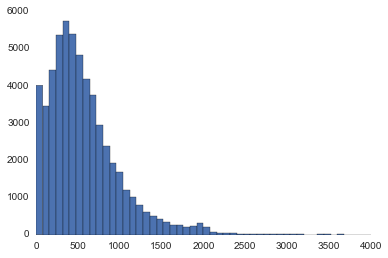

In [63]:
plt.hist(description_lengths, bins = 50, range= (0,4000))

(array([  277.,   179.,   332.,   380.,   608.,   914.,  1109.,  1155.,
         1078.,  1002.,   758.,   607.,   601.,   689.,   704.,   789.,
          839.,   949.,  1118.,  1211.,  1389.,  1495.,  1718.,  1871.,
         2015.,  2209.,  2259.,  2450.,  2525.,  2669.,  2815.,  3096.,
         3674.,  4775.,  5620.,  1232.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.]),
 array([   0.,    4.,    8.,   12.,   16.,   20.,   24.,   28.,   32.,
          36.,   40.,   44.,   48.,   52.,   56.,   60.,   64.,   68.,
          72.,   76.,   80.,   84.,   88.,   92.,   96.,  100.,  104.,
         108.,  112.,  116.,  120.,  124.,  128.,  132.,  136.,  140.,
         144.,  148.,  152.,  156.,  160.,  164.,  168.,  172.,  176.,
         180.,  184.,  188.,  192.,  196.,  200.]),
 <a list of 50 Patch objects>)

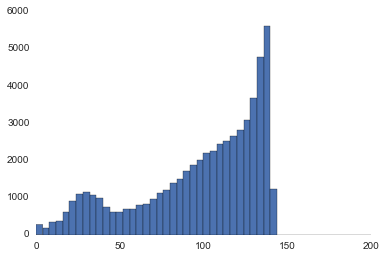

In [40]:
plt.hist(short_description_lengths, bins = 50, range= (0,200))

In [ ]:
list_short_descs = []
for description in orgs_api.find():
    try:
        short_desc = description["properties"]["short_description"]
    except:
        list_short_descs.append("")
        pass
    if short_desc == None:
        list_short_descs.append("")
    else:
        list_short_descs.append(short_desc)

def process_descs(desc):
    if desc:
        desc = re.sub(r"[^A-Za-z]+", ' ', desc)
        desc = desc.strip().lower()
    return desc
        
list_short_descs = map(lambda x: process_descs(x), list_short_descs)
list_short_descs = filter(lambda x: len(x) > 0, list_short_descs)


In [319]:
# stemmer = PorterStemmer()

# def stem_tokens(tokens, stemmer):
#     stemmed = []
#     for item in tokens:
#         stemmed.append(stemmer.stem(item))
#     return stemmed

# def tokenize(text):
#     tokens = word_tokenize(text)
#     stems = stem_tokens(tokens, stemmer)
#     return stems

# a = TfidfVectorizer(stop_words = "english", tokenizer = tokenize)

# b = a.fit_transform(list_short_descs)

nbrs = NearestNeighbors(algorithm = "brute", metric = "cosine")
nbrs.fit(d)


NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_neighbors=5, p=2, radius=1.0)

In [326]:
nbrs.kneighbors(d[16])

(array([[ -8.88178420e-16,   1.96615833e-01,   2.50243237e-01,
           2.55729289e-01,   2.55729289e-01]]),
 array([[   16, 55824, 53091, 48400, 24680]]))

In [327]:
list_short_descs[16]

u'games technology develops mini games for social networks and mobile platforms'

In [331]:
list_short_descs[24680]

u'social game developer'

In [278]:
len(list_short_descs)

56857

In [273]:
len(list_short_descs[18942])

0

In [295]:
from sklearn.decomposition import TruncatedSVD

In [296]:
PCA = TruncatedSVD(n_components = 2000)
c = PCA.fit(b)

In [301]:
d = c.transform(b)

In [302]:
d

array([[  1.32290379e-01,   2.01471793e-02,  -2.12578983e-02, ...,
          1.96862172e-05,   1.03144402e-03,  -1.04106203e-03],
       [  5.56204632e-03,  -4.91723941e-03,  -5.89678709e-03, ...,
         -2.85959831e-03,  -7.89217747e-04,   8.45502235e-04],
       [  4.80214353e-02,   1.73058391e-02,  -3.25140506e-02, ...,
          4.29264772e-03,  -2.14482443e-04,  -3.94928047e-05],
       ..., 
       [  2.51853558e-01,  -1.17843345e-01,   1.45095816e-02, ...,
         -1.20018050e-03,  -2.78530520e-03,   1.23763402e-03],
       [  2.84647408e-01,   2.64042236e-02,  -4.33441033e-02, ...,
          1.07321666e-03,   1.21696652e-04,  -7.38282630e-04],
       [  2.84647408e-01,   2.64042236e-02,  -4.33441033e-02, ...,
          1.07321666e-03,   1.21696652e-04,  -7.38282630e-04]])